<a href="https://colab.research.google.com/github/snikhil17/NLP_course_Simplilearn/blob/main/Assignments/Yelp_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Home Assignment**
- Nikhil Shrestha

## **Problem Statement Home Assignment**

- Dataset: **yelp**

- **SL = 0.45**

- **Task1: Perform EDA on the dataset**
- **Task2: You need to create a model that can predict the ``rating`` the customer may provide in ``final feedback`` based on the ``review received by the customer.``**

## **Reference for Data Dictionary**

About Dataset: https://www.yelp.com/dataset/documentation/main

    // integer, number of useful votes received
    "useful": 0,

    // integer, number of funny votes received
    "funny": 0,

    // integer, number of cool votes received
    "cool": 0

## **Aquiring Data**

In [1]:
!wget https://raw.githubusercontent.com/snikhil17/NLP_course_Simplilearn/main/Assignments/yelp.csv

--2021-11-27 04:34:28--  https://raw.githubusercontent.com/snikhil17/NLP_course_Simplilearn/main/Assignments/yelp.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8091185 (7.7M) [text/plain]
Saving to: ‘yelp.csv’

yelp.csv            100%[===================>]   7.72M  --.-KB/s    in 0.09s   

2021-11-27 04:34:29 (86.8 MB/s) - ‘yelp.csv’ saved [8091185/8091185]



## **Loading Libraries**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
import datetime as dt

import re
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentimentAnalyser = SentimentIntensityAnalyzer()
from nltk.corpus import stopwords
nltk.download('stopwords')
import string

from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble  import GradientBoostingClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
import statistics

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Loading Data**

In [3]:
df = pd.read_csv('yelp.csv')
df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


## **Checking:** 
 - Null Values
 - Duplicates
 - Constant Variable: Variable with only one value

In [5]:
print(f"Number of Missing Values: {df.isnull().sum().sum()}")
print(f"Number of Duplicates: {df.duplicated().sum()}")
print(f"Number of Constant Variables: {(df.nunique()==1).sum()}")

Number of Missing Values: 0
Number of Duplicates: 0
Number of Constant Variables: 1


In [6]:
# Which Variable is the constant variable
(df.nunique()==1)

business_id    False
date           False
review_id      False
stars          False
text           False
type            True
user_id        False
cool           False
useful         False
funny          False
dtype: bool

In [7]:
# Dropping Constant Variable (type) from the Dataset
df.drop('type', axis=1, inplace=True)

## **Converting date column from string to datetime format**

In [8]:
df.date = df.date.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

# **Task1: Perform EDA on the dataset**

In [9]:
"""Checking if data is balanced or unbalanced"""
df.stars.value_counts()

4    3526
5    3337
3    1461
2     927
1     749
Name: stars, dtype: int64

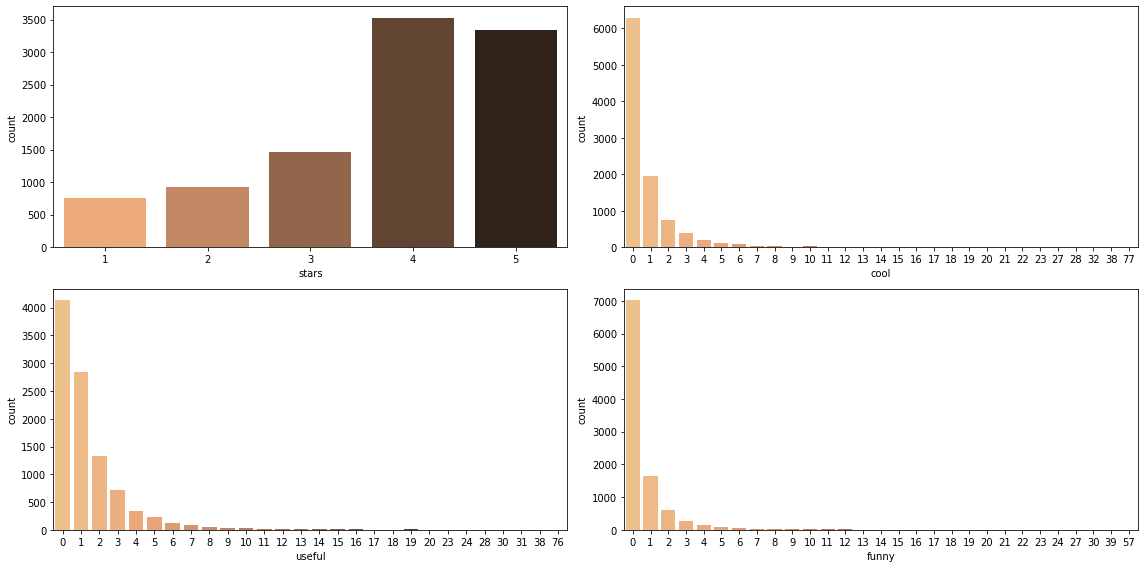

In [10]:
plt.figure(figsize= (16,8))
for i,col in enumerate(['stars' ,	'cool', 	'useful' ,	'funny']):
  plt.subplot(2,2, i+1)
  sns.countplot(df[col], palette = 'copper_r')
  plt.tight_layout()

### **Observations:**
---
- **Data is unbalanced because ``stars`` variable has different value counts.**
- Most reviews given in order : 4, 5, 3
- In terms of votes reveived as cool, useful and funny we can observe that Most of the time people didnt vote, i.e. vote is 0. 
- But there are times when people have also voted a lot, specifically, **cool has highest of 77 votes**, **useful: 76** and **funny: 57**


## **Top-10 users in terms of Number of Reviews**

In [11]:
user_agg=df.groupby('user_id').agg({'review_id':['count'],'date':['min','max'],
                                'useful':['sum'],'funny':['sum'],'cool':['sum'],
                               'stars':['mean']})

print("          Top 10 Users in Yelp")
user_agg.sort_values([('review_id','count')],ascending=False).head(10)


          Top 10 Users in Yelp


review_id       date             ... funny cool     stars
                           count        min        max  ...   sum  sum      mean
user_id                                                 ...                     
fczQCSmaWF78toLEmb0Zsw        38 2007-12-14 2012-07-19  ...   147  263  4.131579
0CMz8YaO3f8xu4KqQgKb9Q        25 2007-01-22 2007-07-20  ...    34   44  4.120000
90a6z--_CUrl84aCzZyPsg        22 2008-02-27 2012-07-23  ...    22   44  3.954545
4ozupHULqGyO42s3zNUzOQ        18 2010-06-26 2012-12-10  ...    59   97  4.388889
0mqHhdKEdak_A1FBhFNXqA        18 2010-04-19 2012-10-19  ...    11    2  3.055556
wHg1YkCzdZq9WBJOTRgxHQ        17 2008-06-13 2012-02-01  ...    79   89  3.823529
0bNXP9quoJEgyVZu9ipGgQ        16 2008-12-05 2012-04-28  ...    58   88  2.875000
_PzSNcfrCjeBxSLXRoMmgQ        16 2009-11-11 2013-01-04  ...    13   17  3.750000
JgDkCER12uiv4lbpmkZ9VA        15 2008-05-27 2011-01-29  ...    15   15  2.933333
joIzw_aUiNvBTuGoytrH7g        15 2009-03-29 2012-01-12  ...    18   22  2.933333

[10 rows x 7 columns]

### **Table Details:**
---
- Above table shows ``Top 10 users in Yelp`` in terms of number of reviews given by them.
- Since ``review_id`` is has all unique values, review_id is used to display the count of user (when grouped). Hence, it represents the ``number of reviews given by the user``.
- ``Date min and max date``, which represents user's first and the last review date.
- Sum of funny cool and useful votes shows how many times a user had found review as funny cool or useful. 
- Mean of ``stars`` given by user in his/her review.

### **Observations:**
---
- Top user have given 38 reviews
- Top user is also actively voting the reviews, which proves that user is reading the reviews and hence spending more time on the site.


## **Top-10 ``business`` in terms of Number of Reviews and Stars**

In [12]:
business_agg=df.groupby('business_id').agg({'review_id':['count'],'date':['min','max'],
                                'useful':['sum'],'funny':['sum'],'cool':['sum'],
                               'stars':['mean']})

In [13]:
print("          Top 10 business in terms of Number of Reviews and Stars in Yelp")
business_agg.sort_values([('review_id','count'), ('stars','mean')],ascending=False).head(10)

          Top 10 business in terms of Number of Reviews and Stars in Yelp


review_id       date             ... funny cool     stars
                           count        min        max  ...   sum  sum      mean
business_id                                             ...                     
JokKtdXU7zXHcr20Lrk29A        37 2008-01-14 2012-09-30  ...    17   26  4.513514
ntN85eu27C04nwyPa8IHtw        37 2006-05-12 2012-12-31  ...    16   24  3.945946
hW0Ne_HTHEAgGF1rAdmR-g        34 2008-12-07 2012-10-27  ...    66   50  3.264706
WNy1uzcmm_UHmTyR--o5IA        32 2008-12-26 2012-10-23  ...    21   30  4.343750
VVeogjZya58oiTxK7qUjAQ        31 2007-11-16 2012-09-17  ...    30   47  4.193548
V1nEpIRmEa1768oj_tuxeQ        30 2008-06-10 2012-12-16  ...    20   37  4.333333
SDwYQ6eSu1htn8vHWv128g        25 2006-01-25 2012-11-19  ...    11   16  4.240000
uKSX1n1RoAzGq4bV8GPHVg        25 2010-01-28 2012-12-30  ...    19   10  3.920000
-sC66z4SO3tR7nFCjfQwuQ        24 2009-06-30 2012-12-06  ...    28   40  4.458333
EWMwV5V9BxNs_U6nNVMeqw        24 2006-06-12 2012-11-25  ...    31   50  4.166667

[10 rows x 7 columns]

### **Table Details:**
---
- Above table shows ``business`` in terms of Number of Reviews and Stars.
- Since ``review_id`` is has all unique values, review_id is used to display the count of ``business_id`` (when grouped). Hence, it represents the ``number of reviews obtained by business``.
- ``Date min and max date``, which represents user's first and the last review obtained.
- Sum of funny cool and useful votes shows how many times a business_review was considered: useful, funny, cool. 
- Median of ``stars`` obtained by business.

### **Observations:**
---
- Top business (in terms of reviews and stars) have reveived 37 reviews and stars mean is 4.5.
- Top business received 32 useful votes, out of which 34 times users found the reviews useful.
- But if we observe 5th business_id, we will see that it has received 31 reviews and 79 users have found that as useful review, and mean rating given to 5th observation is 4.1 (approx). 

## **Checking the impact of lenght of text in review written:**
- Just a thought, very bad reviews are usually longer than very good reviews.
- Let's check this

In [14]:
df1 = df.copy()

In [15]:
df1['num_char_review'] = df1['text'].apply(lambda x :  len(x)) # Creating a new column 'num_char_review'

In [16]:
df1.drop('text', axis =1, inplace = True)  # Dropping 'text' col from df1 dataset
df1.head(3)                                # Printing first 3 rows of df1.

,business_id,date,review_id,stars,user_id,cool,useful,funny,num_char_review
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,0hT2KtfLiobPvh6cDC8JQg,0,1,0,76


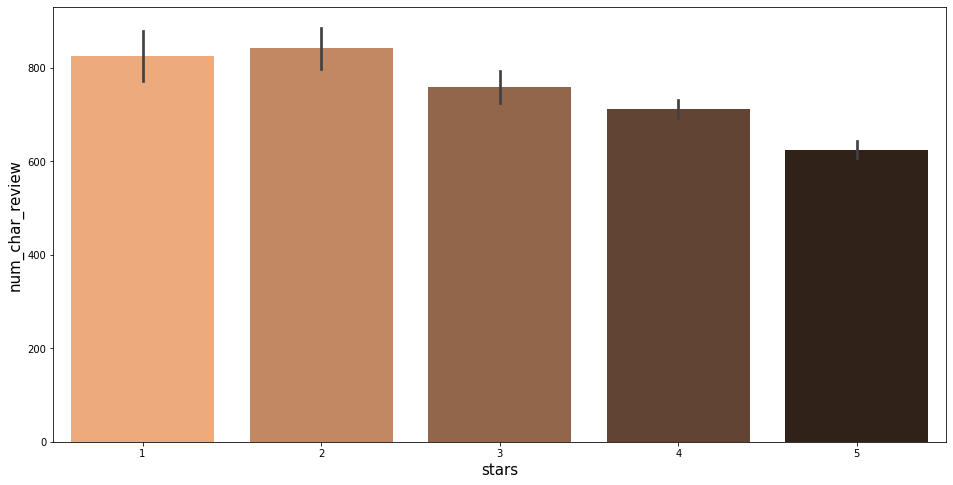

In [17]:
plt.figure(figsize= (16,8))
sns.barplot(x = 'stars',  y = 'num_char_review' , data = df1, palette = 'copper_r')
plt.xlabel('stars', fontsize = 15)
plt.ylabel('num_char_review' ,fontsize = 15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

## **Observation:**
- Above plot shows bar plot between ``Stars given by user to the review`` and ``number of characters in the review``.
- Reviews with ``1-star`` has more characters in the review than reviews with ``5-stars``

# **TASK- 2: Create a model that can predict the ``rating`` the customer may provide in final feedback ``based on the review received by the customer.``**
- Use Vader to create a new column for postive and negative review based on sentimental analysis.
- Text preprocessing
- Use vader for sentimental analysis
- Create generalized model with and without vader-sentimental-analysis. Use **accuracy score** to check the generalization of each model.
- Model will be multi-class model. Classes being: **1,2,3,4,5**
- Evaluate or check the quality of model. Since **data is unbalanced** we use **f1-score** to check the quality of each model.


## **Using vader to create a new column ``labelFromVADER`` which will have value 'positive' if ``compound value`` is more than 0.5, else 'negative'**

In [18]:
df['labelFromVADER'] = df['text'].apply(lambda review: "pos" if sentimentAnalyser.polarity_scores(review)['compound'] > 0.5 else "neg")

## **Text preprocessing:**
- Use decontracted function to decontract the words like ``don't`` -> ``do not`` etc.
- Remove words like **not, nor, no** from english stopwords
- Normalize (Remove Punctuations and lower case text)
- Tokenization
- Remove Stopwords
- Stemming

In [19]:
# Use decontracted function to decontract the words like don't -> do not etc.
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

df['text'] = df['text'].apply(lambda x: decontracted(x))

In [20]:
df.head()

,business_id,date,review_id,stars,text,user_id,cool,useful,funny,labelFromVADER
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,pos
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,pos
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,0hT2KtfLiobPvh6cDC8JQg,0,1,0,pos
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",uZetl9T0NcROGOyFfughhg,1,2,0,pos
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,pos


**Create Features and Labels:**
- Since its mentioned that we will be given only review text from the user and using only that we need to predict the stars or rating user will give. 
- Hence only ``text``, ``labelFromVADER`` and ``stars`` column for creating features and labels.

In [21]:
features = df.iloc[:,[4,9]].values
label = df.iloc[:,[3]].values

**Remove words like not, nor, neither from english stopwords**

In [22]:
# Remove words like not, nor, neither from english stopwords
stop_words = stopwords.words('english')
for i in ['nor', 'not', 'no']:
  stop_words.remove(i)


In [23]:
'no' in stop_words

False

**Text Preprocessing Function**

In [24]:
# Creating an instance of PorterStemmer class, for stemming.
stemObject = PorterStemmer()

In [25]:
"""Creating a function for:
- Normalize (Remove Punctuations and lower case text)
- Tokenization
- Remove Stopwords
- Stemming
"""


def textPreprocessing(document):
  #1. Remove Punctuations
  sentWithoutPunct = ''.join([char for char in document  if char not in string.punctuation])
  #2. Extract words out of the sentences
  words = sentWithoutPunct.split()
  #3. Normalize the data (lowercase | Uppercase | NormalCase)
  wordNormalized = [word.lower() for word in words]
  # 4. Remove Stopwords
  vocabulary = [word for word in wordNormalized if word not in stop_words]
  # 5. Apply Stemming
  stem_words = [stemObject.stem(word) for word in vocabulary]
  # bigrams = [ ' '.join(grams) for grams in ngrams(stem_words, 2)]
  # 6. Exclude those words with NER prop and perform Stemming with other words

  return stem_words



### **Creating BOW**

In [26]:
# Create BOW in SKlearn
wordVector  = CountVectorizer(analyzer = textPreprocessing)
finalWordVectorVocab  = wordVector.fit(features )       # Build the Vocabulary for features
bagOfWords = finalWordVectorVocab.transform(features) # To create BOW vader_features

In [27]:
bagOfWords.shape

(10000, 64604)

In [28]:
"""Vocab created"""
# printing only first 10
{key: finalWordVectorVocab.vocabulary_[key] for key in finalWordVectorVocab.vocabulary_.keys() & \
 list(finalWordVectorVocab.vocabulary_.keys())[:10]}


{'birthday': 11973,
 'breakfast': 13048,
 'excellent.': 24067,
 'made': 36870,
 'outsid': 42744,
 'perfect': 44242,
 'sit': 52624,
 'took': 58765,
 'weather': 62328,
 'wife': 62991}

### **Apply TFIDF Algo on BOW to create a feature set**

In [29]:
# Apply TFIDF Algo on BOW to create a feature set
tfidfObject = TfidfTransformer().fit(bagOfWords)  #Calc IDF Values

# Lets create Numeric Feature set
processedFeatures = tfidfObject.transform(bagOfWords)

In [30]:
for i in range(0,5):
  # Create Train Test Split (90% training -10% testing)
  X_train, X_test, y_train, y_test = train_test_split(processedFeatures, label , 
                                                                              stratify = df['stars'],
                                                                              test_size= 0.2, random_state =i)
  # X_test = X_test.toarray()
  # X_train = X_train.toarray()
  # model = XGBClassifier( seed = 7, n_estimators=i,learning_rate=0.001, max_depth=6)
  # model = KNeighborsClassifier( n_neighbors=i)
  # model = MultinomialNB( alpha = 1)
  # model = DecisionTreeClassifier( criterion='entropy',  max_depth=i, random_state=7)
  model = AdaBoostClassifier(learning_rate=0.5,  n_estimators=40, random_state=i)
  model.fit(X_train, y_train)
  tr_preds = model.predict(X_train)
  ts_preds = model.predict(X_test)
  train_score = metrics.accuracy_score(y_train, tr_preds)
  test_score = metrics.accuracy_score(y_test, ts_preds)
  # if test_score > train_score and test_score > CL:
  print(f"random_state: {i}")
  print(f"Score of Training set: \n{train_score}")
  print(f"Score of Testing set: \n{test_score}")
  print("="*50)
  # break



random_state: 0
Score of Training set: 
0.467875
Score of Testing set: 
0.4445
random_state: 1
Score of Training set: 
0.45875
Score of Testing set: 
0.45
random_state: 2
Score of Training set: 
0.463
Score of Testing set: 
0.449
random_state: 3
Score of Training set: 
0.4675
Score of Testing set: 
0.455
random_state: 4
Score of Training set: 
0.4655
Score of Testing set: 
0.4395


### Obseravations: 
- Even after trying different Parameters and combination in textPreprocessing a **generalized model was not achieved.** 
- Other insights observed: 
  - **BOW-features gave better results than TF-IDF-Features**
  - using **strtify = label in train_test_split when using TF-IDF improves accuracy, but doesn't make the model generalized.**
- Hence, trying another approach: change the values of ``stars`` variable to Bad, Neutral and Good, where all the ratings below 3 becomes ``bad``, above 3: ``good`` and ratings == 3: ``Neutral``

In [31]:
# Creating a function to convert star values to string.
def convert_stars(star):
  if star == 1 or star == 2:
    star = "bad"
  elif star == 3:
    star = "neutral"
  else:
    star = "good"
  return star


In [32]:
df['stars'] = df.stars.apply(lambda x : convert_stars(x))
df.stars.value_counts()

good       6863
bad        1676
neutral    1461
Name: stars, dtype: int64

In [33]:
label = df.iloc[:,[3]].values

In [34]:
CL = 0.55
for i in range(40,90,10):
  # Create Train Test Split (90% training -10% testing)
  X_train, X_test, y_train, y_test = train_test_split(processedFeatures, label , 
                                                                              # stratify = df['stars'],
                                                                              test_size= 0.2, random_state =4)
  # X_test = X_test.toarray()
  # X_train = X_train.toarray()
  # model = SVC(C= 0.5, random_state=i)
  # model = RandomForestClassifier(n_estimators=21, max_depth =i )
  # model = MultinomialNB()
  # model = DecisionTreeClassifier( criterion='entropy',  max_depth=i+2, random_state=7)
  model = AdaBoostClassifier(learning_rate=0.5,  n_estimators=i, random_state=4)
  model.fit(X_train, y_train)
  tr_preds = model.predict(X_train)
  ts_preds = model.predict(X_test)
  train_score = metrics.accuracy_score(y_train, tr_preds)
  test_score = metrics.accuracy_score(y_test, ts_preds)
  if test_score > train_score and test_score > CL:
    print(f"n_estimators: {i}")
    print(f"Score of Training set: \n{train_score}")
    print(f"Score of Testing set: \n{test_score}")
    print("="*50)
  # break



n_estimators: 40
Score of Training set: 
0.732875
Score of Testing set: 
0.7375
n_estimators: 50
Score of Training set: 
0.73825
Score of Testing set: 
0.742
n_estimators: 60
Score of Training set: 
0.7465
Score of Testing set: 
0.7485
n_estimators: 70
Score of Training set: 
0.751
Score of Testing set: 
0.7555


### **Observation:**
- We can use n_estimators as 70, as it gave highest test_accuracy, its greater than train_accuracy and decided CL. 
- We finally have a generalized model. 
- Data is unbalanced, hence f1-score for quality check of the model.


In [35]:
CL = 0.55

# Create Train Test Split (90% training -10% testing)
X_train, X_test, y_train, y_test = train_test_split(processedFeatures, label ,  test_size= 0.2, random_state =4)

model = AdaBoostClassifier(learning_rate=0.5,  n_estimators=70, random_state=4)
model.fit(X_train, y_train)
tr_preds = model.predict(X_train)
ts_preds = model.predict(X_test)
train_score = metrics.accuracy_score(y_train, tr_preds)
test_score = metrics.accuracy_score(y_test, ts_preds)

print(f"Score of Training set: \n{train_score}")
print(f"Score of Testing set: \n{test_score}")
print("="*50)

Score of Training set: 
0.751
Score of Testing set: 
0.7555


## **Checking Model on Whole data for quality test.**


In [36]:
CL = 0.55

# Create Train Test Split (90% training -10% testing)
X_train, X_test, y_train, y_test = train_test_split(processedFeatures, label , test_size= 0.2, random_state =4)

preds = model.predict(processedFeatures)
Classification_report = metrics.classification_report(label, preds)
confusion_matrix = metrics.confusion_matrix(label, preds)

print(f"Classification Report on Whole data: \n{Classification_report}\n")
print("="*50)
print(f"\nConfusion Matrix on Whole data: \n{confusion_matrix}")


Classification Report on Whole data: 
              precision    recall  f1-score   support

         bad       0.75      0.40      0.52      1676
        good       0.76      0.98      0.85      6863
     neutral       0.56      0.11      0.18      1461

    accuracy                           0.75     10000
   macro avg       0.69      0.49      0.52     10000
weighted avg       0.73      0.75      0.70     10000



Confusion Matrix on Whole data: 
[[ 664  960   52]
 [  94 6695   74]
 [ 128 1173  160]]


## **Deployment Code**

In [37]:
print(df.stars[33])
print()
print(df['text'].iloc[33])

good

I went here again when I got back to Phoenix after being gone for six months. This is one of my mom is favorite places to eat and I can understand why. The ravioli and the miso soup are so delicious! The wine was ok and I would recommend one of their elixirs over an alcohol beverage. Still a pretty delicious place to go in Phoenix.


In [41]:
# Take the review from user as input.
query_review = input("Enter an yelp review: ")

# Perform All preprocessing step on the given review.
decon_query = decontracted(query_review)
preprocessed_query = textPreprocessing(decon_query)  
bagOfWords = finalWordVectorVocab.transform(preprocessed_query)
processedquery = tfidfObject.transform(bagOfWords)
print(f"\nPredictions: {model.predict(processedquery)}\n")
print(f"Selecting first value as final prediction : {model.predict(processedquery)[0]}\n")
print(f"Selecting mode as final prediction : {statistics.mode(model.predict(processedquery))}\n")



Enter an yelp review: I went here again when I got back to Phoenix after being gone for six months. This is one of my mom is favorite places to eat and I can understand why. The ravioli and the miso soup are so delicious! The wine was ok and I would recommend one of their elixirs over an alcohol beverage. Still a pretty delicious place to go in Phoenix.

Predictions: ['good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good' 'good'
 'good']

Selecting first value as final prediction : good

Selecting mode as final prediction : good



In [ ]:
no